In [11]:
# 06_final_report.ipynb

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Ensure folders exist (assuming you run this from notebooks/)
os.makedirs("../reports", exist_ok=True)
os.makedirs("../models", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

DATA_PATH = "../data/processed/cleaned_fake_news.csv"
VECT_PATH = "../models/tfidf_vectorizer.pkl"
TOKENIZER_PATH = "../models/tokenizer.pkl"

LOGREG_PATH = "../models/logistic_regression.pkl"
NB_PATH = "../models/naive_bayes.pkl"
RF_PATH = "../models/random_forest.pkl"

LSTM_PATH = "../models/lstm_model.h5"       # optional
BILSTM_PATH = "../models/bilstm_model.h5"   # optional (rename to what you saved)


In [12]:
df = pd.read_csv(DATA_PATH)
X = df["content"].fillna("")
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Test size:", X_test.shape[0])


Test size: 8980


In [13]:
tfidf = joblib.load(VECT_PATH)
X_test_tfidf = tfidf.transform(X_test)
X_test_tfidf.shape


(8980, 10000)

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# You must have saved the tokenizer earlier: joblib.dump(tokenizer, TOKENIZER_PATH)
tokenizer = joblib.load(TOKENIZER_PATH)

MAX_LEN = 300  # keep same as used in training
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")
X_test_pad.shape


(8980, 300)

In [15]:
log_reg = joblib.load(LOGREG_PATH)
nb = joblib.load(NB_PATH)
rf = joblib.load(RF_PATH)

ml_models = {
    "Logistic Regression": log_reg,
    "Naive Bayes": nb,
    "Random Forest": rf
}


In [16]:
from tensorflow.keras.models import load_model

dl_models = {}

# LSTM (if saved)
if os.path.exists(LSTM_PATH):
    dl_models["LSTM"] = load_model(LSTM_PATH)

# BiLSTM (if saved)
if os.path.exists(BILSTM_PATH):
    dl_models["BiLSTM"] = load_model(BILSTM_PATH)

dl_models.keys()


dict_keys(['LSTM', 'BiLSTM'])

In [17]:
def evaluate_binary(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (Fake)": precision_score(y_true, y_pred),
        "Recall (Fake)": recall_score(y_true, y_pred),
        "F1 (Fake)": f1_score(y_true, y_pred),
    }

results = []

# --- ML models (use TF-IDF) ---
for name, model in ml_models.items():
    y_pred = model.predict(X_test_tfidf)
    metrics = evaluate_binary(y_test, y_pred)
    results.append({"Model": name, **metrics})

# --- DL models (use padded sequences) ---
for name, model in dl_models.items():
    prob = model.predict(X_test_pad, verbose=0)
    y_pred = (prob > 0.5).astype("int32")
    metrics = evaluate_binary(y_test, y_pred)
    results.append({"Model": name, **metrics})

results_df = pd.DataFrame(results).sort_values("F1 (Fake)", ascending=False).reset_index(drop=True)
results_df


,Model,Accuracy,Precision (Fake),Recall (Fake),F1 (Fake)
0,Random Forest,0.996771,0.996595,0.997232,0.996913
1,BiLSTM,0.988641,0.992285,0.985945,0.989105
2,Logistic Regression,0.987862,0.989959,0.986797,0.988376
3,LSTM,0.958241,0.939037,0.984029,0.961007
4,Naive Bayes,0.928174,0.930683,0.932070,0.931376


In [18]:
results_df.to_csv("../reports/model_comparison.csv", index=False)

with open("../reports/model_comparison.json", "w") as f:
    json.dump(results_df.to_dict(orient="records"), f, indent=2)

print("Saved: ../reports/model_comparison.csv & .json")


Saved: ../reports/model_comparison.csv & .json


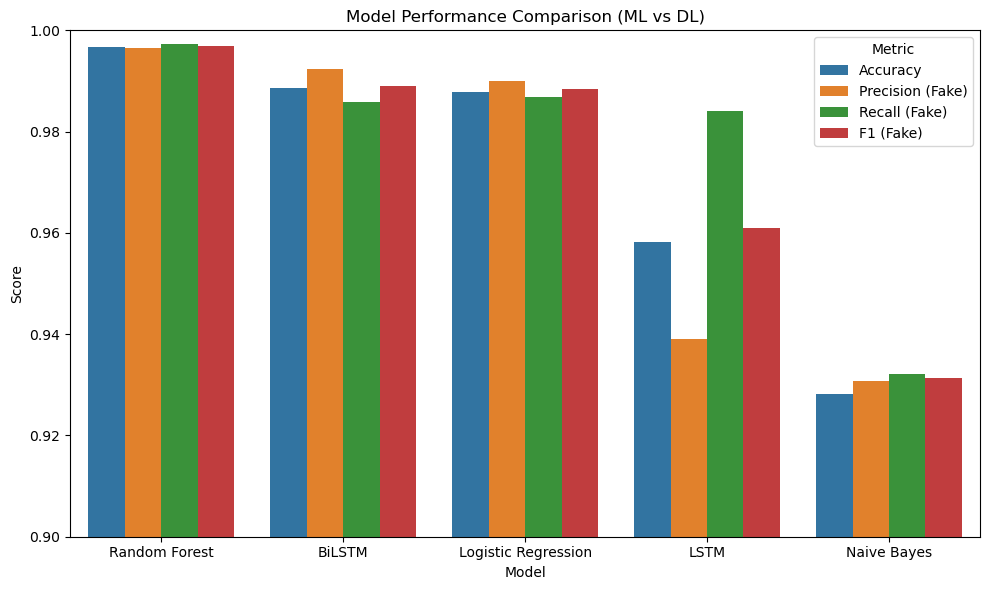

Saved: ../reports/model_performance_comparison.png


In [19]:
plt.figure(figsize=(10,6))
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(data=melted, x="Model", y="Score", hue="Metric")
plt.ylim(0.9, 1.0)  # zoom to high-performance range; adjust if needed
plt.title("Model Performance Comparison (ML vs DL)")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("../reports/model_performance_comparison.png", dpi=300)
plt.show()

print("Saved: ../reports/model_performance_comparison.png")

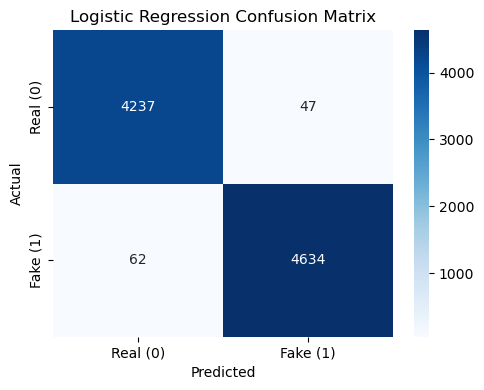

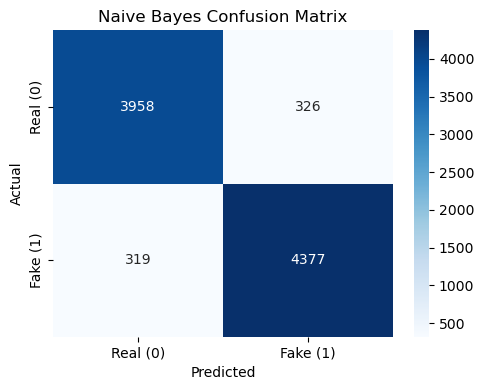

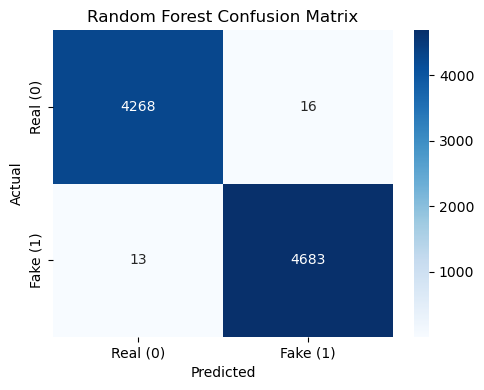

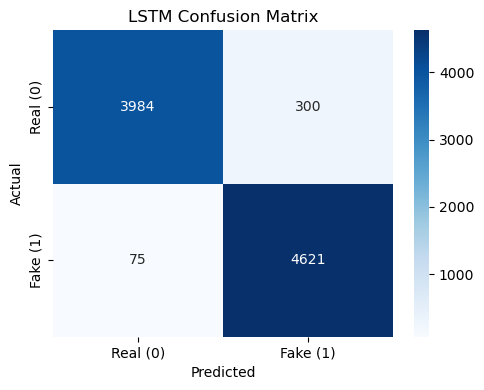

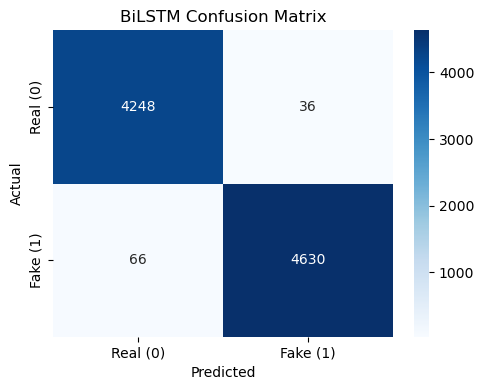

In [20]:
def plot_and_save_cm(y_true, y_pred, title, path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Real (0)", "Fake (1)"],
                yticklabels=["Real (0)", "Fake (1)"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(path, dpi=300)
    plt.show()

# ML confusion matrices
for name, model in ml_models.items():
    y_pred = model.predict(X_test_tfidf)
    out = f"../reports/cm_{name.replace(' ', '_').lower()}.png"
    plot_and_save_cm(y_test, y_pred, f"{name} Confusion Matrix", out)

# DL confusion matrices
for name, model in dl_models.items():
    prob = model.predict(X_test_pad, verbose=0)
    y_pred = (prob > 0.5).astype("int32")
    out = f"../reports/cm_{name.lower()}.png"
    plot_and_save_cm(y_test, y_pred, f"{name} Confusion Matrix", out)


In [21]:
def save_classification_report(y_true, y_pred, path, title="Classification Report"):
    rep = classification_report(y_true, y_pred, digits=3)
    with open(path, "w") as f:
        f.write(title + "\n\n")
        f.write(rep)
    print(f"Saved: {path}")

# ML reports
for name, model in ml_models.items():
    y_pred = model.predict(X_test_tfidf)
    save_classification_report(y_test, y_pred, f"../reports/report_{name.replace(' ', '_').lower()}.txt", title=name)

# DL reports
for name, model in dl_models.items():
    prob = model.predict(X_test_pad, verbose=0)
    y_pred = (prob > 0.5).astype("int32")
    save_classification_report(y_test, y_pred, f"../reports/report_{name.lower()}.txt", title=name)


Saved: ../reports/report_logistic_regression.txt
Saved: ../reports/report_naive_bayes.txt
Saved: ../reports/report_random_forest.txt
Saved: ../reports/report_lstm.txt
Saved: ../reports/report_bilstm.txt


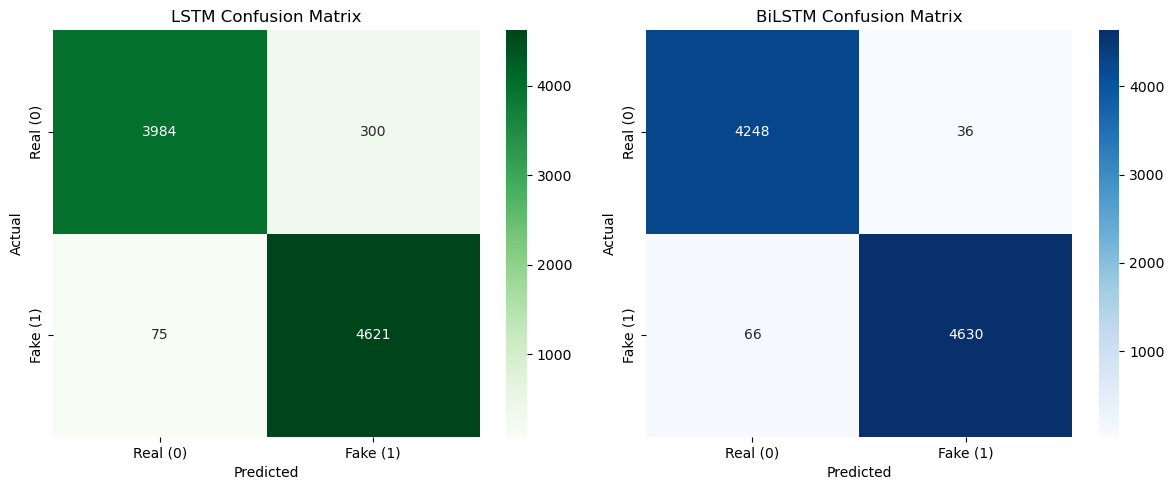

Saved: ../reports/cm_lstm_vs_bilstm.png


In [22]:
if "LSTM" in dl_models and "BiLSTM" in dl_models:
    lstm_prob = dl_models["LSTM"].predict(X_test_pad, verbose=0)
    bilstm_prob = dl_models["BiLSTM"].predict(X_test_pad, verbose=0)

    lstm_pred = (lstm_prob > 0.5).astype("int32")
    bilstm_pred = (bilstm_prob > 0.5).astype("int32")

    cm_lstm = confusion_matrix(y_test, lstm_pred)
    cm_bilstm = confusion_matrix(y_test, bilstm_pred)

    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap="Greens", ax=axes[0],
                xticklabels=["Real (0)", "Fake (1)"],
                yticklabels=["Real (0)", "Fake (1)"])
    axes[0].set_title("LSTM Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap="Blues", ax=axes[1],
                xticklabels=["Real (0)", "Fake (1)"],
                yticklabels=["Real (0)", "Fake (1)"])
    axes[1].set_title("BiLSTM Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.savefig("../reports/cm_lstm_vs_bilstm.png", dpi=300)
    plt.show()

    print("Saved: ../reports/cm_lstm_vs_bilstm.png")


    Model  Precision    Recall  F1-Score
0    LSTM   0.939037  0.984029  0.961007
1  BiLSTM   0.992285  0.985945  0.989105


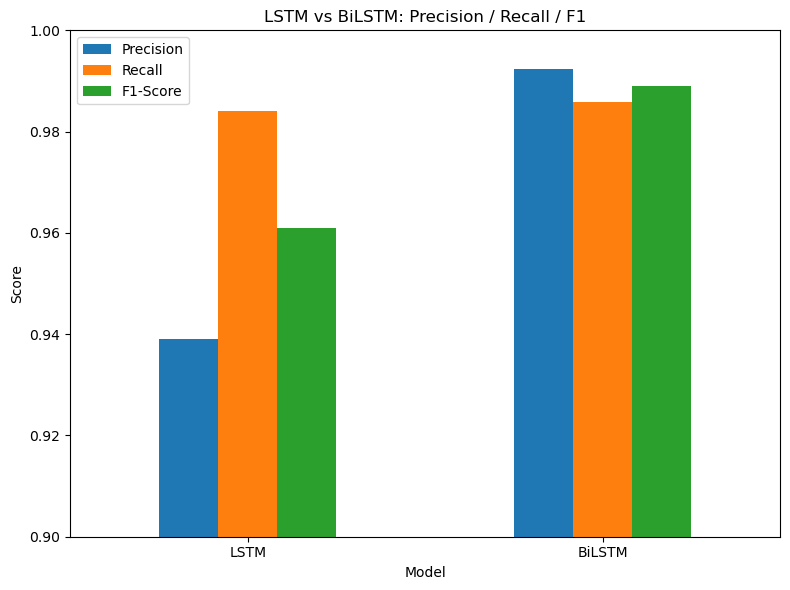

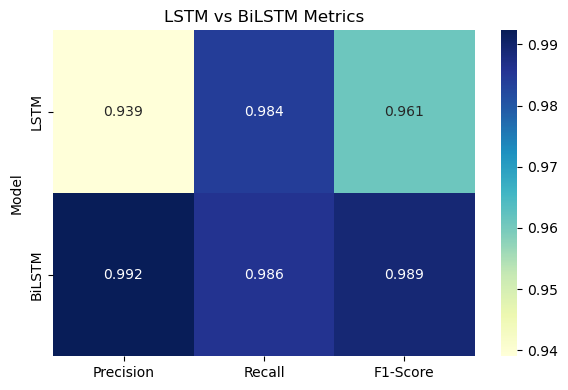

Saved: ../reports/lstm_bilstm_metrics.csv / *_bar.png / *_heatmap.png


In [23]:
if "LSTM" in dl_models and "BiLSTM" in dl_models:
    from sklearn.metrics import precision_score, recall_score, f1_score

    lstm_prec = precision_score(y_test, lstm_pred)
    lstm_rec  = recall_score(y_test, lstm_pred)
    lstm_f1   = f1_score(y_test, lstm_pred)

    bilstm_prec = precision_score(y_test, bilstm_pred)
    bilstm_rec  = recall_score(y_test, bilstm_pred)
    bilstm_f1   = f1_score(y_test, bilstm_pred)

    metrics_df = pd.DataFrame({
        "Model": ["LSTM", "BiLSTM"],
        "Precision": [lstm_prec, bilstm_prec],
        "Recall": [lstm_rec, bilstm_rec],
        "F1-Score": [lstm_f1, bilstm_f1]
    })

    metrics_df.to_csv("../reports/lstm_bilstm_metrics.csv", index=False)
    print(metrics_df)

    # Bar chart
    metrics_df.set_index("Model").plot(kind="bar", figsize=(8,6))
    plt.ylim(0.9, 1.0)
    plt.title("LSTM vs BiLSTM: Precision / Recall / F1")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig("../reports/lstm_bilstm_metrics_bar.png", dpi=300)
    plt.show()

    # Heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(metrics_df.set_index("Model"), annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("LSTM vs BiLSTM Metrics")
    plt.tight_layout()
    plt.savefig("../reports/lstm_bilstm_metrics_heatmap.png", dpi=300)
    plt.show()

    print("Saved: ../reports/lstm_bilstm_metrics.csv / *_bar.png / *_heatmap.png")
